In [1]:
# Install / upgrade dependencies (ConfigSpace >=0.6.0 needed for 'q' arg used by Ray BOHB)
%pip install -U tables ray ipywidgets tensorboard tensorboardX optuna vmdpy seaborn

  Using cached tables-3.10.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.0 kB)
  Using cached ray-2.49.2-cp312-cp312-manylinux2014_x86_64.whl.metadata (21 kB)
  Using cached ipywidgets-8.1.7-py3-none-any.whl.metadata (2.4 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorboardx-2.6.4-py3-none-any.whl.metadata (6.2 kB)
  Using cached optuna-4.5.0-py3-none-any.whl.metadata (17 kB)
  Using cached vmdpy-0.2-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached numexpr-2.13.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (9.0 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
  Using cached blosc2-3.9.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (7.1 kB)
  Using cached widgetsnbextension-4.0.14-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.15-py3-none-any.whl.m

### Imports

### Manual Transformer Training

In [10]:
import importlib
import transformer_model
importlib.reload(transformer_model)

<module 'transformer_model' from '/dss/dsshome1/05/ge96ton2/GridForecast/1_timeseries/4_transformer/transformer_model.py'>

In [1]:
from transformer_model import TransformerTrainer, TransformerConfig
import torch, math, os, json

manual_cfg = {
    # Preprocessing settings
    '_data': {
        'hdf_data_path': '/dss/dsshome1/05/ge96ton2/GridForecast/0_preprocessing/Data/ts_train.h5',
        'key_X': "X",
        'key_y': "y",
        'train_grids': "all",
        'test_ratio': 0.2,
        'random_state': 42,
        'X_BASE_COLS':        [#'DHI', 'DNI', 'GHI', 
                               'T', 
                               'demand_net_active_pre',
                               #"mob_avail", "mobility", #"mob_last_avail", 
                               "heat_water", "heat_space", "cop_avg",
                               # "PV_prod_100", 
                               "PV_prod_expected",
                               #"PV_prod_true",
                               "res_bldng_area_base_sum", "nonres_bldng_area_base_sum", 'bldng_area_floors_sum', #"bldng_area_floors_sum"
                               'n_cars', "n_res_buildings", "n_nonres_buildings", 'n_flats', 'n_occ', # "n_radiator", #'n_bldng',
                               'n_lines', 'tot_R_grid', 'regiostar7',
                              ],
        'TARGET_COLS':        [#'demand_net_active_post', 'demand_net_reactive_post'],
                               "demand_net_active_post", "demand_net_reactive_post"],
        'ZERO_BASE_FEATURES': [#"DHI", "GHI", "DNI"],
                               #"GHI"
                              ],
        'LOG1P_COLS':         ["n_lines", "tot_R_grid"],
        'TS_PERIODS':         [8760, 168, 24, 12
                               # 8760, 168, 24, 12, 8
                              ],
        'VMD_COLS':           [#'DHI', "DNI", "GHI", "T", "demand_net_active_pre"],
                               #'DHI', "DNI", "GHI", "T", "demand_net_active_pre", "PV_prod_expected"],
                               "demand_net_active_pre", "heat_water", "heat_space", "cop_avg", "PV_prod_expected", "T"],
                               #"demand_net_active_pre", "heat_water", "heat_space", "cop_avg", "mob_avail", "mobility", "PV_prod_expected"], #"PV_prod_100"],
        'VMD_K_MODES':         2,
        'VMD_APPROACH':        "read",  # None | read | write
    },
    # Model / architecture
    'input_mlp_layers': 2,
    'input_mlp_hidden': 256*2,
    'input_dropout': 0.1,
    'output_mlp_layers': 2,
    'output_mlp_hidden': 256*2,
    'output_dropout': 0.1,
    'd_model': 256*2,
    'num_heads': 8,
    'ff_dim': 256*8,
    'attn_dropout': 0,
    'ffn_dropout': 0,
    'num_transformer_layers': 2,
    'activation': 'gelu',
    # Aggregation settings
    'core_len': 120,
    'pad_hours': 24,
    'aggregation_mode': "conv",
    "conv_padding": 12,
    'agg_hours': 1,
    # Training
    'learning_rate': 1e-3,
    'weight_decay': 0.01,
    'optimizer': 'adamw',
    'scheduler': 'none',
    'scheduler_epochs': 40,
    'epochs': 40,
    'batch_size': 256,
    'grad_clip': 0,
    'loss_type': "alpha_peak", #'mae_maex',  # try: 'mae_maex', 'alpha_peak'
    'multi_target_lambda': 1,
    'patience': 3,
    # reporting and Others
    'seed': 42,
    "num_workers": 14,
    'compile_model': True,
    'bottom_rung_report': None,
    'full_metrics_every': 5,
}

transformer_trainer = TransformerTrainer(manual_cfg)
print('Train batches:', len(transformer_trainer.train_loader), ', Val batches:', len(transformer_trainer.val_loader))
print('Input dims ->', transformer_trainer.cfg.in_features, ', Output dims ->', transformer_trainer.cfg.out_features)

Index(['mob_avail', 'mobility', 'res_bldng_area_base_sum',
       'nonres_bldng_area_base_sum', 'bldng_area_floors_sum', 'n_cars',
       'n_res_buildings', 'n_nonres_buildings', 'n_flats', 'n_occ', 'n_lines',
       'tot_R_grid', 'regiostar7', 'sin_8760', 'cos_8760', 'sin_168',
       'cos_168', 'sin_24', 'cos_24', 'demand_net_active_pre_1',
       'demand_net_active_pre_2', 'demand_net_active_pre_3',
       'demand_net_active_pre_res', 'heat_water_1', 'heat_water_2',
       'heat_water_3', 'heat_water_res', 'heat_space_1', 'heat_space_2',
       'heat_space_3', 'heat_space_res', 'cop_avg_1', 'cop_avg_2', 'cop_avg_3',
       'cop_avg_res', 'PV_prod_expected_1', 'PV_prod_expected_2',
       'PV_prod_expected_3', 'PV_prod_expected_res', 'T_1', 'T_2', 'T_3',
       'T_res'],
      dtype='object')
Index(['demand_net_active_post_nopwrflw', 'demand_net_reactive_post_nopwrflw'], dtype='object')


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Train batches: 228 , Val batches: 57
Input dims -> 43 , Output dims -> 2


/usr/local/lib/python3.12/dist-packages/ray/train/_internal/session.py:657: UserWarning: `get_trial_dir` is meant to only be called inside a function that is executed by a Tuner or Trainer. Returning `None`.
  warnings.warn(


In [4]:
import pandas as pd
def print_metrics(metrics):
    df=pd.DataFrame(metrics, index = [0])
    df.columns = [col[4:] if col.startswith('val_') else col for col in df.columns]
    def print_line(df, col_range):
        if not df.columns[col_range].empty: print(df[df.columns[col_range]].to_string(line_width=160, index=False))
    for cols in [slice(0,7), slice(7,12), slice(12,17), slice(17,22), slice(22,27), slice(27,32)]: print_line(df, cols)

for i in range(8):
    metrics = transformer_trainer.train_one_epoch()
    print_metrics(metrics)

 epoch  train_loss     loss  best_val_loss    lr
     3    0.215802 0.183089       0.183089 0.001
 epoch  train_loss     loss  best_val_loss    lr
     4    0.203518 0.175298       0.175298 0.001
 epoch  train_loss     loss  best_val_loss    lr  P_Agg. Import MAPE  P_Agg. Feed-In MAPE
     5    0.196215 0.171289       0.171289 0.001            0.041595             0.191758
 P_MA(E/MAEx) (1h)  P_Peak Import MAPE (1h)  P_Peak Feed-In MAPE (1h)  P_Peak Import Mean Δt (1h)  P_Peak Feed-In Mean Δt (1h)
          0.200893                 0.065117                   0.14102                  217.110553                   551.849246
 P_MA(E/MAEx) (2h)  P_Peak Import MAPE (2h)  P_Peak Feed-In MAPE (2h)  P_Peak Import Mean Δt (2h)  P_Peak Feed-In Mean Δt (2h)
          0.177427                 0.052295                  0.119154                  193.517588                   496.874372
 P_MA(E/MAEx) (4h)  P_Peak Import MAPE (4h)  P_Peak Feed-In MAPE (4h)  P_Peak Import Mean Δt (4h)  P_Peak Feed-In Me

Metric Results (original scale):
                                  Test       Train
Agg. Import MAPE              0.029730    0.035235
Agg. Feed-In MAPE             0.183671    0.195231
MA(E/MAEx) (1h)               0.180889    0.191412
Peak Import MAPE (1h)         0.077251    0.083653
Peak Feed-In MAPE (1h)        0.138064    0.145657
Peak Import Mean Δt (1h)    237.341709  301.583229
Peak Feed-In Mean Δt (1h)   559.552764  518.060075
MA(E/MAEx) (2h)               0.157673    0.166399
Peak Import MAPE (2h)         0.058238    0.061575
Peak Feed-In MAPE (2h)        0.116928    0.121832
Peak Import Mean Δt (2h)    240.884422  256.315394
Peak Feed-In Mean Δt (2h)   485.889447  487.832290
MA(E/MAEx) (4h)               0.138600    0.146353
Peak Import MAPE (4h)         0.046069    0.048515
Peak Feed-In MAPE (4h)        0.108048    0.130129
Peak Import Mean Δt (4h)    169.849246  202.703379
Peak Feed-In Mean Δt (4h)   481.145729  445.662078
MA(E/MAEx) (12h)              0.116687    0.12298

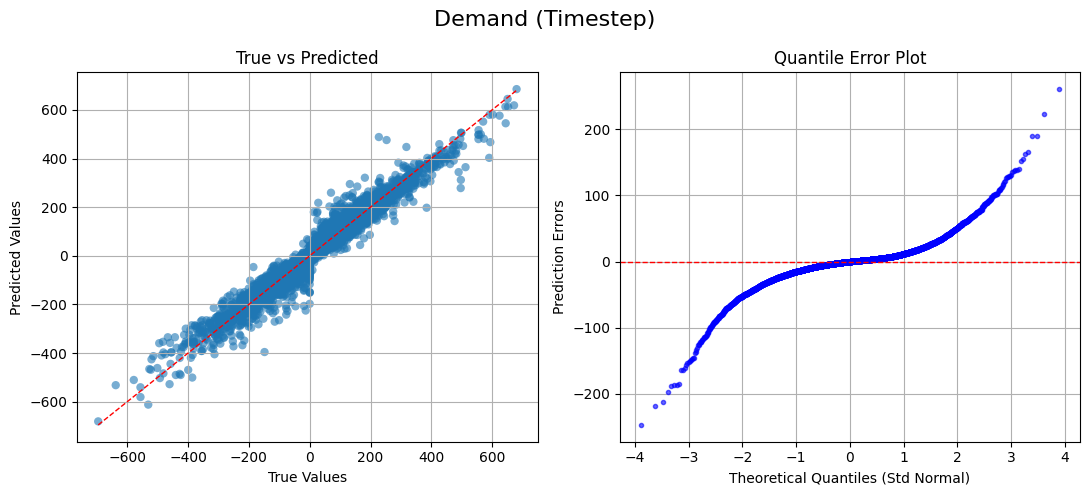

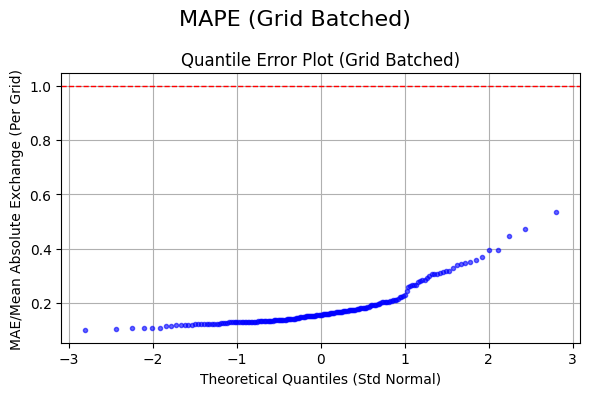

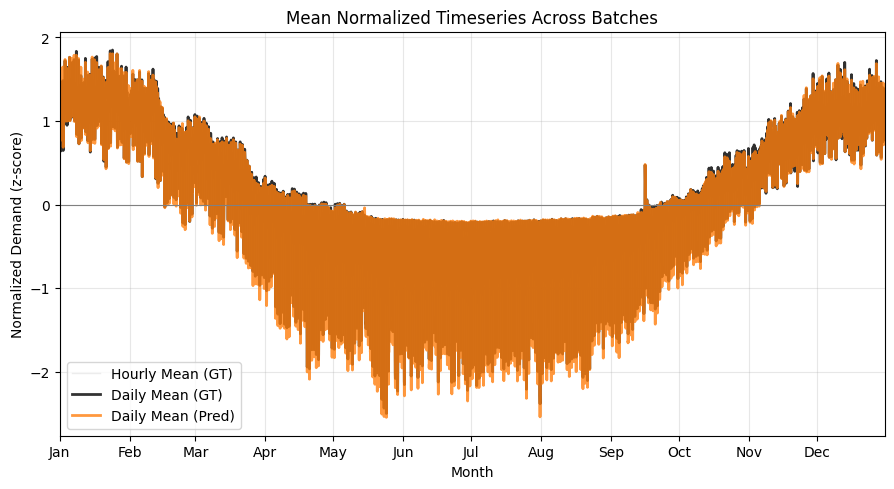

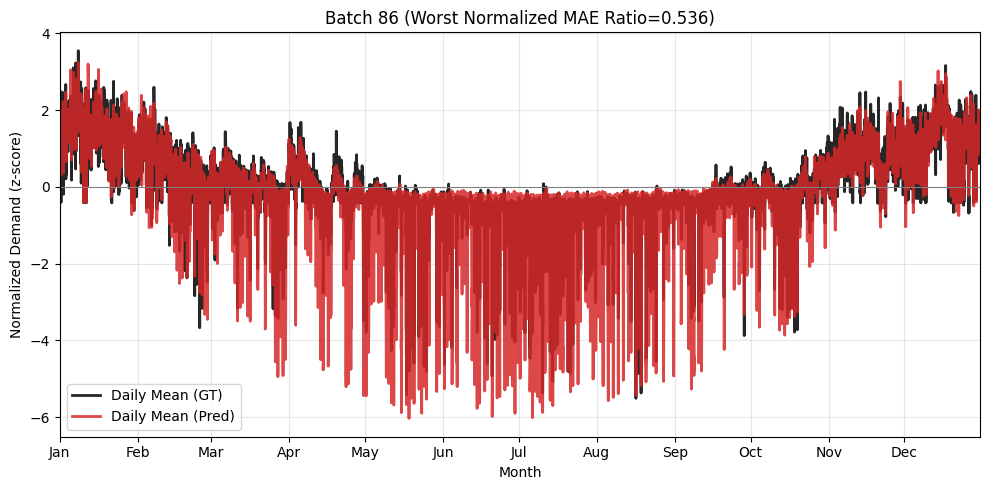

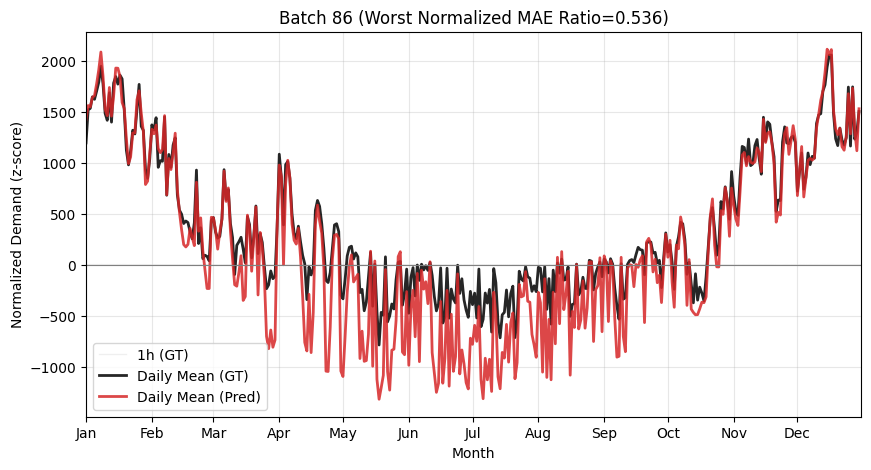

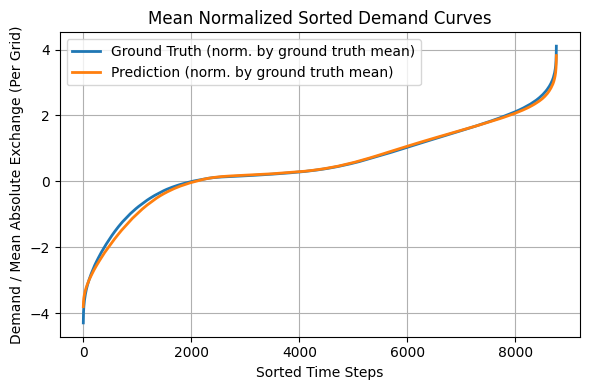

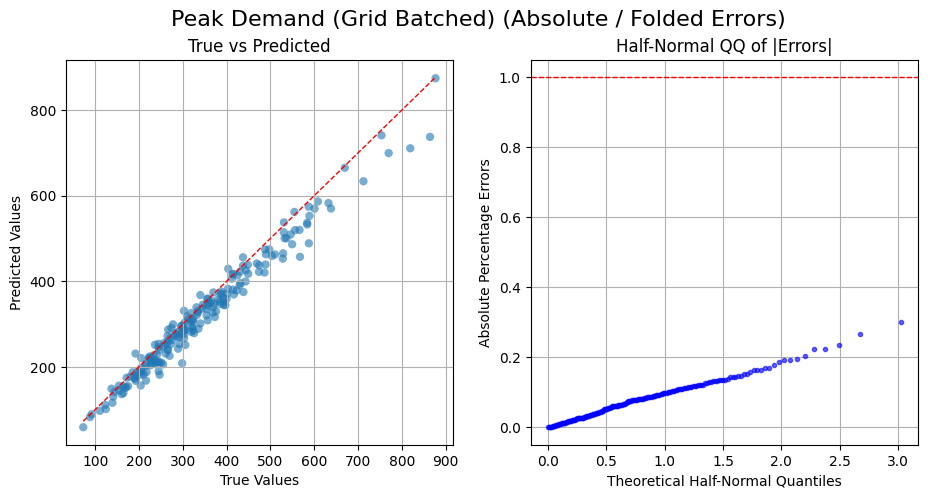

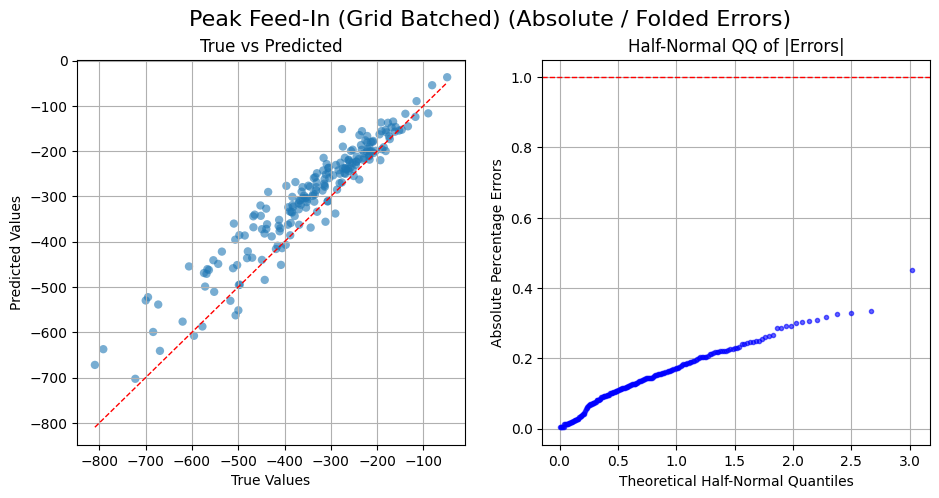

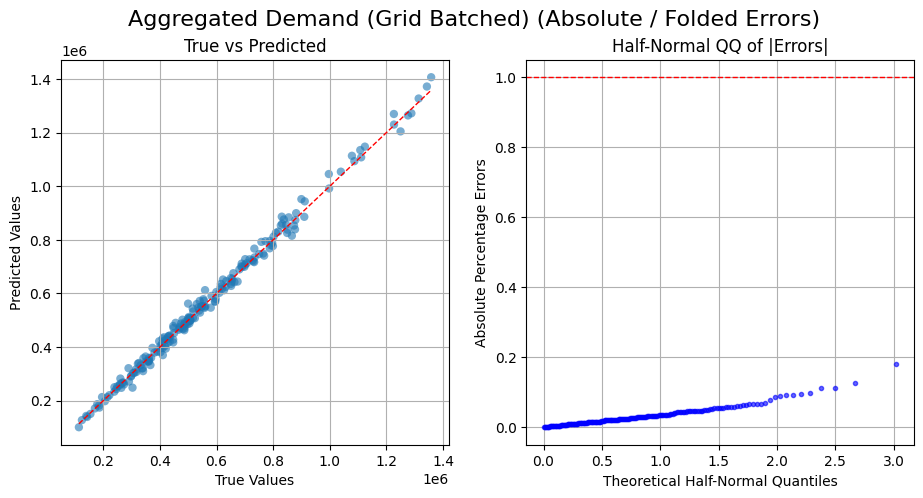

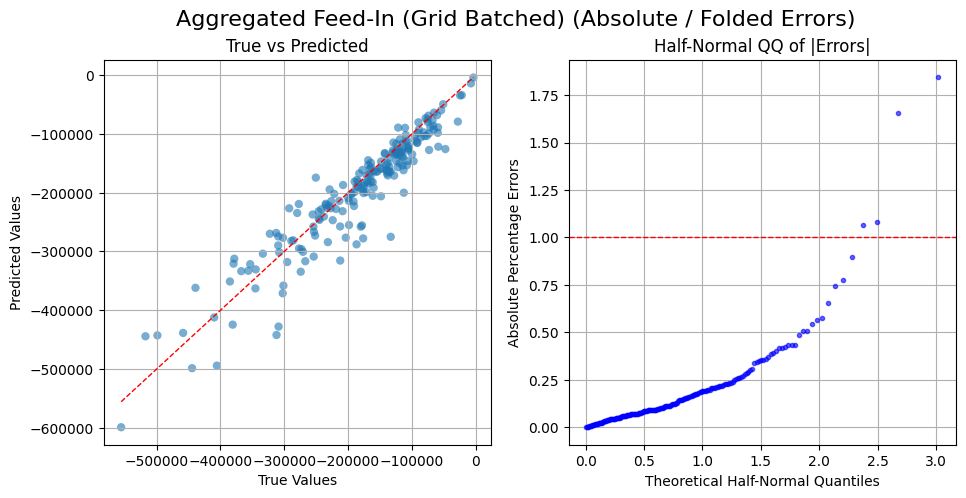

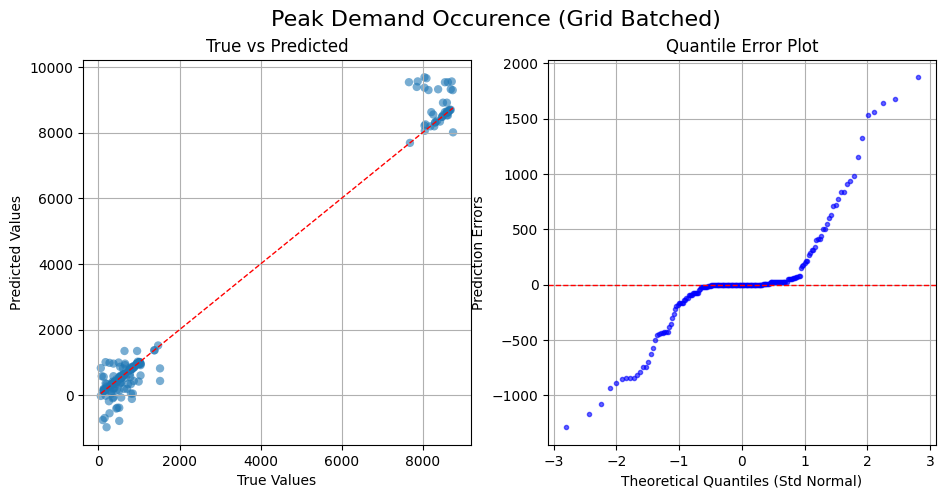

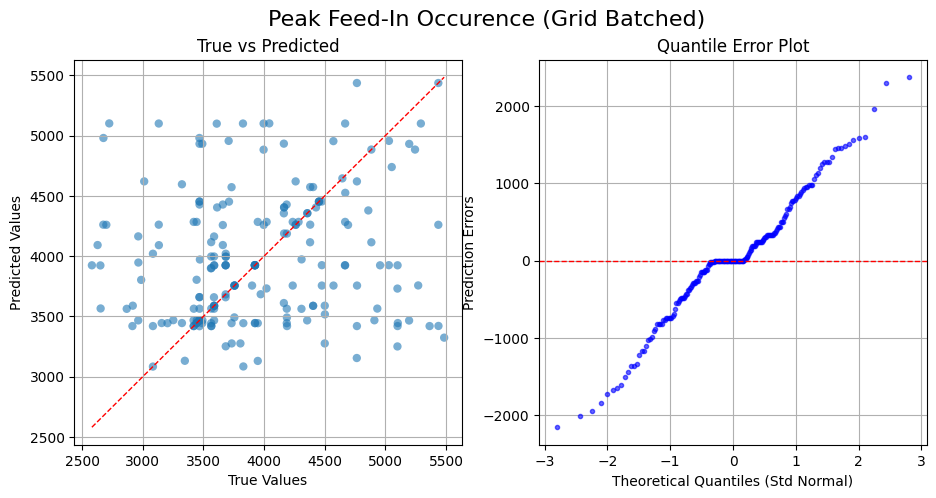

Metric Results (original scale):
                                    Test         Train
Agg. Import MAPE            3.186110e+18  2.862550e+18
Agg. Feed-In MAPE           5.450576e-02  1.069273e-01
MA(E/MAEx) (1h)             1.548560e-01  2.062648e-01
Peak Import MAPE (1h)       1.247527e+16  1.132622e+16
Peak Feed-In MAPE (1h)      5.854070e-02  8.044467e-02
Peak Import Mean Δt (1h)    2.292744e+03  2.233109e+03
Peak Feed-In Mean Δt (1h)   3.074874e+02  3.617860e+02
MA(E/MAEx) (2h)             1.385272e-01  1.887660e-01
Peak Import MAPE (2h)       2.018245e+16  1.870436e+16
Peak Feed-In MAPE (2h)      4.411571e-02  6.954881e-02
Peak Import Mean Δt (2h)    1.975387e+03  1.959272e+03
Peak Feed-In Mean Δt (2h)   2.220101e+02  2.955119e+02
MA(E/MAEx) (4h)             1.210750e-01  1.703063e-01
Peak Import MAPE (4h)       2.870697e+16  2.686060e+16
Peak Feed-In MAPE (4h)      3.950617e-02  6.410169e-02
Peak Import Mean Δt (4h)    1.548925e+03  1.592491e+03
Peak Feed-In Mean Δt (4h)   1.74

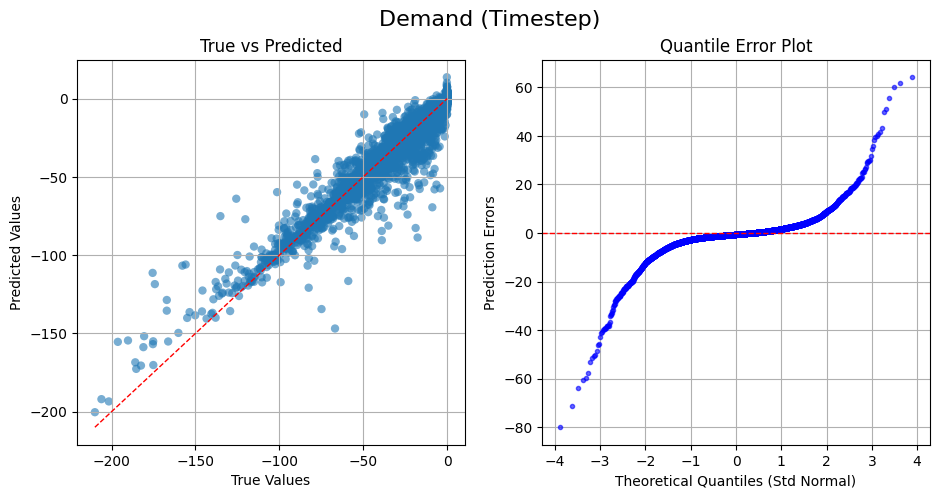

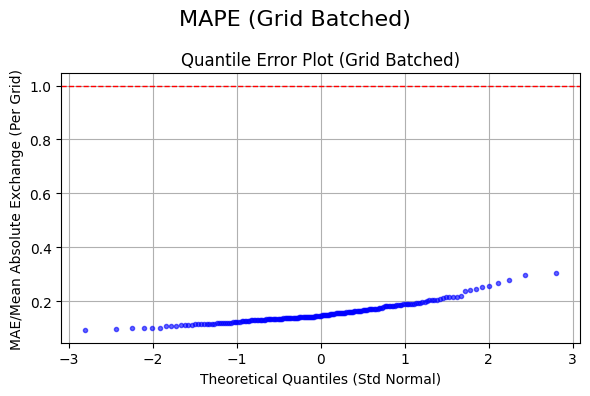

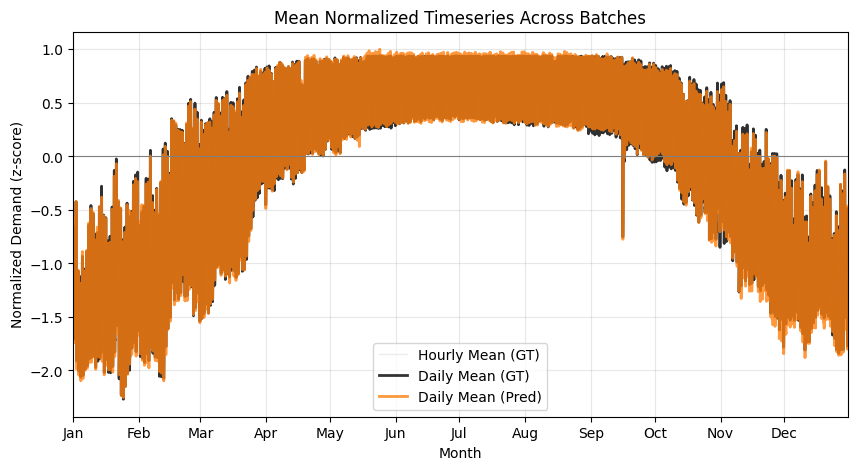

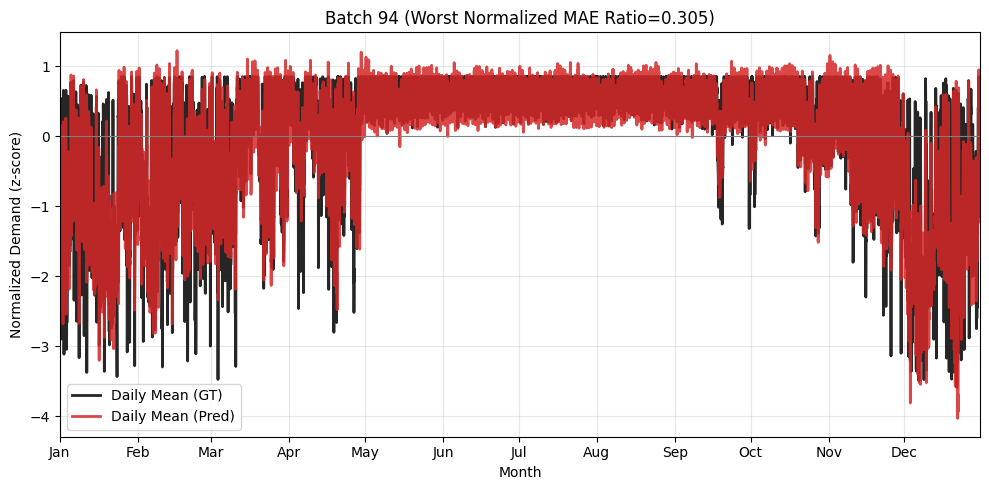

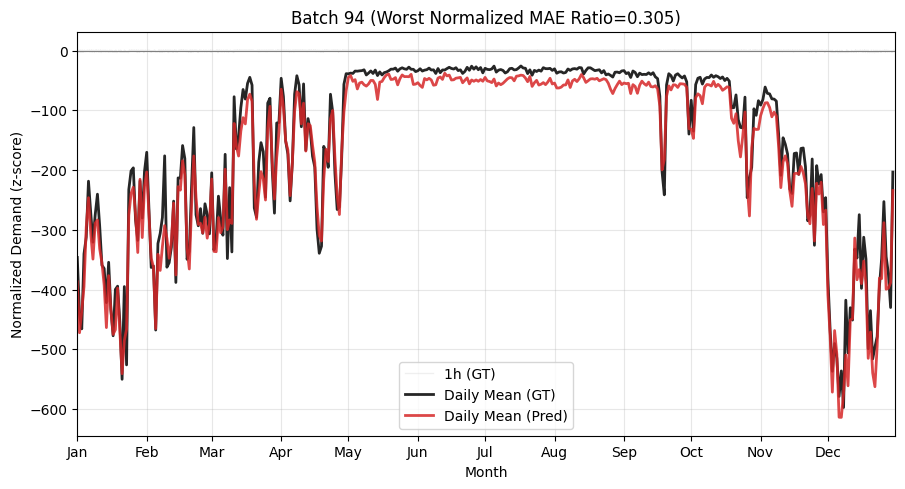

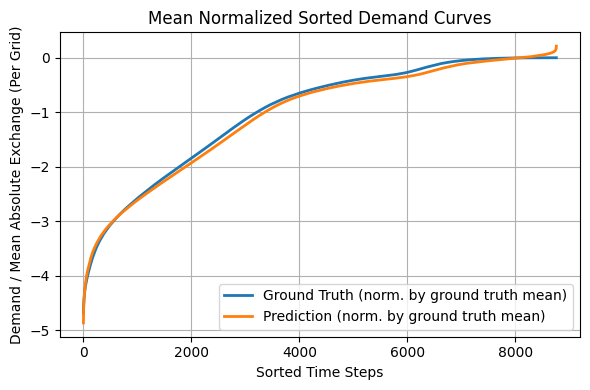

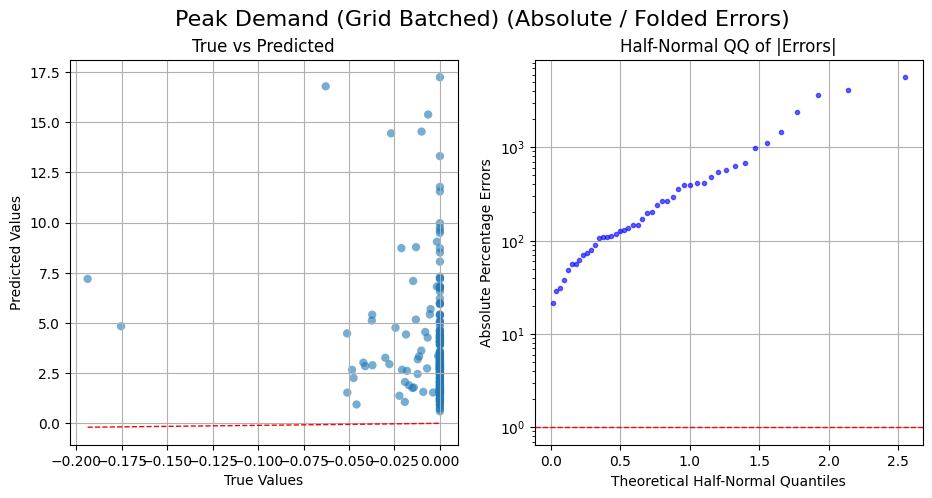

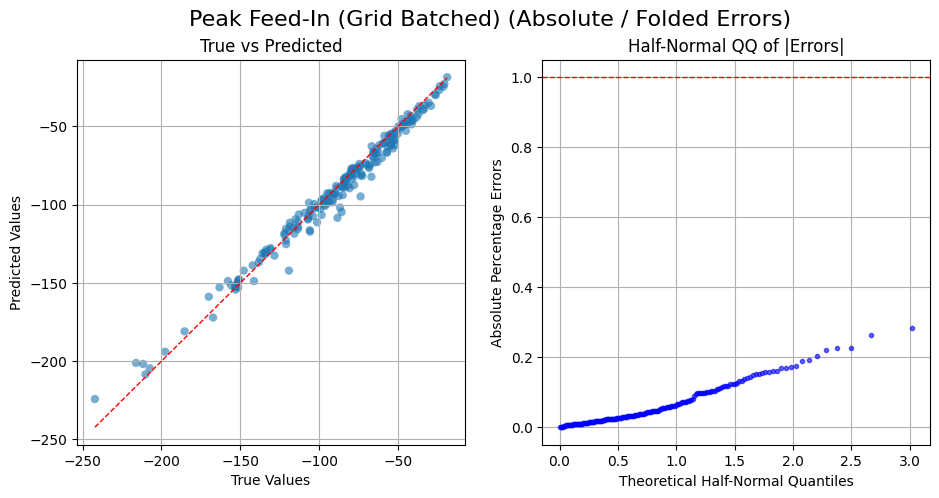

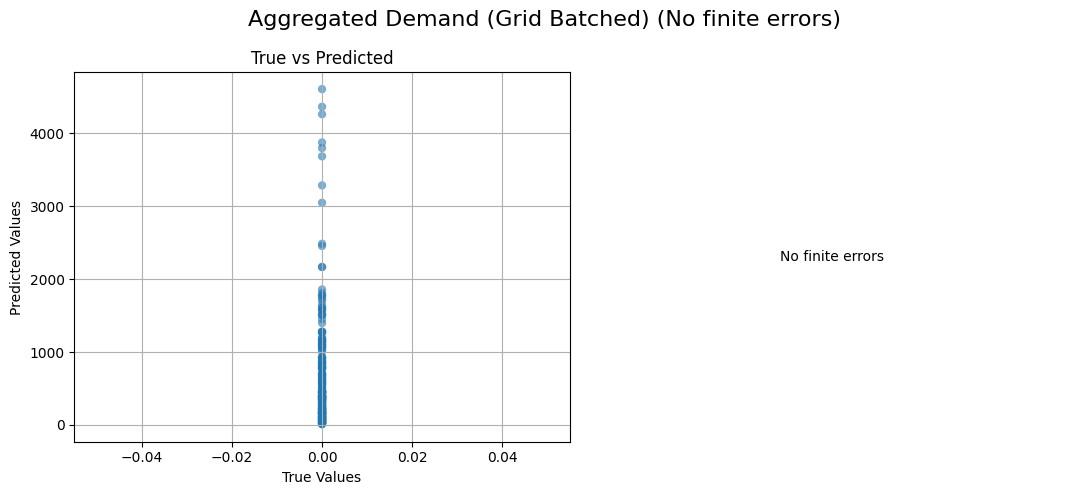

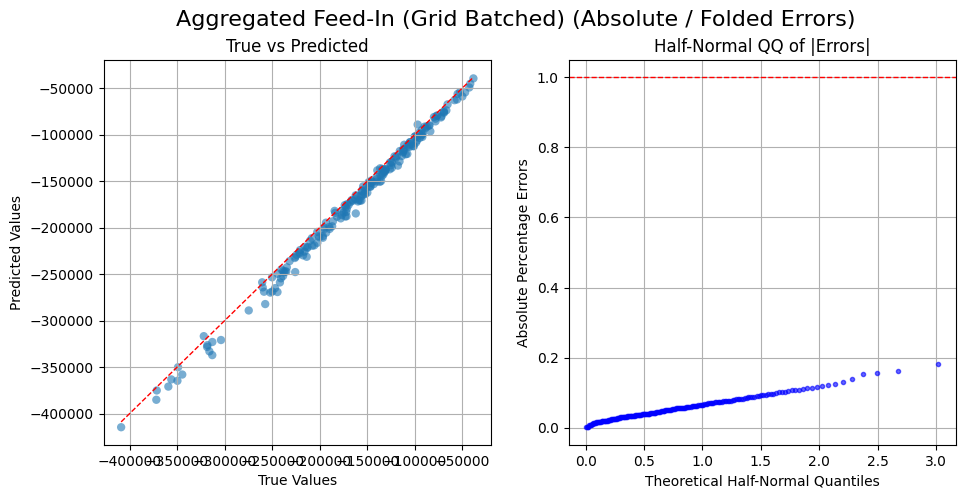

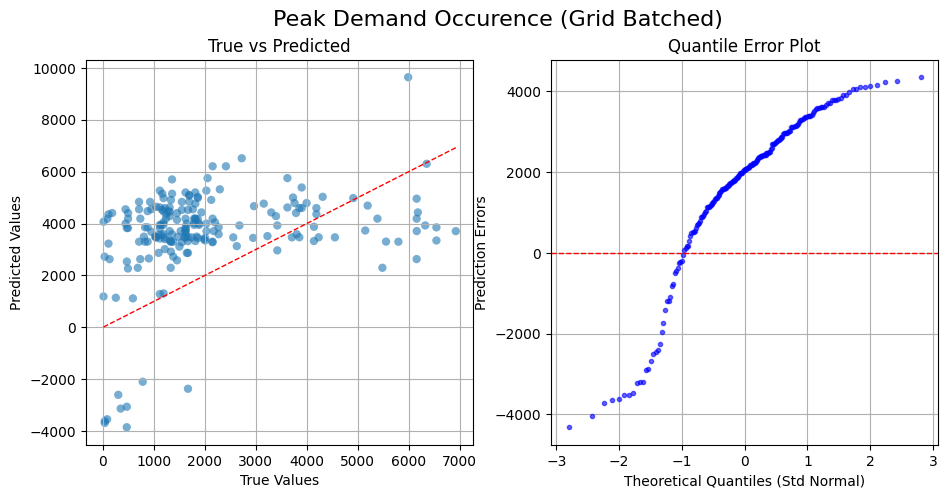

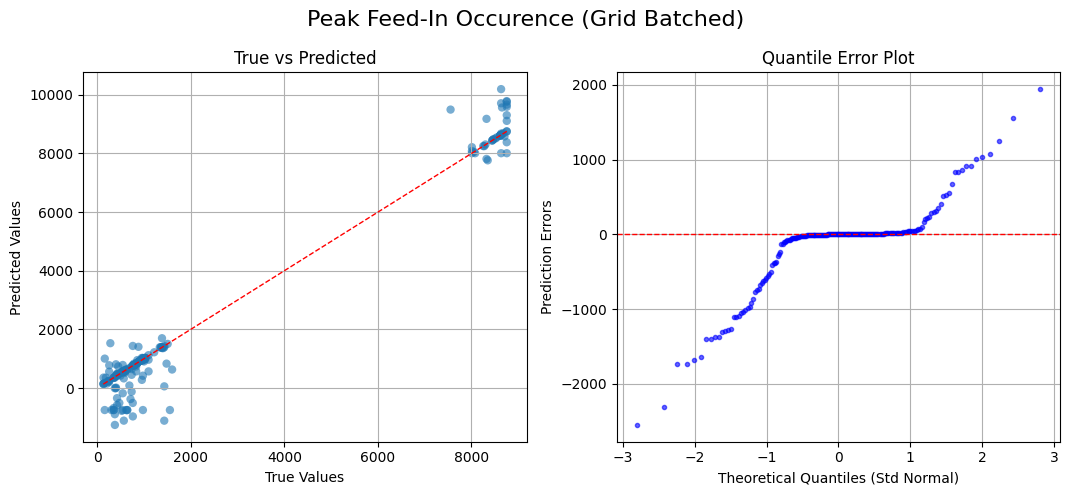

Metric Results (original scale):
                                 Test       Train
Agg. Import MAPE             0.038138    0.051096
MA(E/MAEx) (1h)              0.173343    0.185699
Peak Import MAPE (1h)        0.090679    0.097763
Peak Import Mean Δt (1h)   674.819095  775.032541
MA(E/MAEx) (2h)              0.150456    0.161527
Peak Import MAPE (2h)        0.075259    0.078764
Peak Import Mean Δt (2h)   615.678392  736.828536
MA(E/MAEx) (4h)              0.130461    0.140976
Peak Import MAPE (4h)        0.065616    0.069752
Peak Import Mean Δt (4h)   530.211055  620.095119
MA(E/MAEx) (12h)             0.100361    0.110436
Peak Import MAPE (12h)       0.035114    0.043085
Peak Import Mean Δt (12h)  235.417085  205.516896
MA(E/MAEx) (24h)             0.083959    0.094327
Peak Import MAPE (24h)       0.029162    0.037156
Peak Import Mean Δt (24h)  114.331658  137.391740


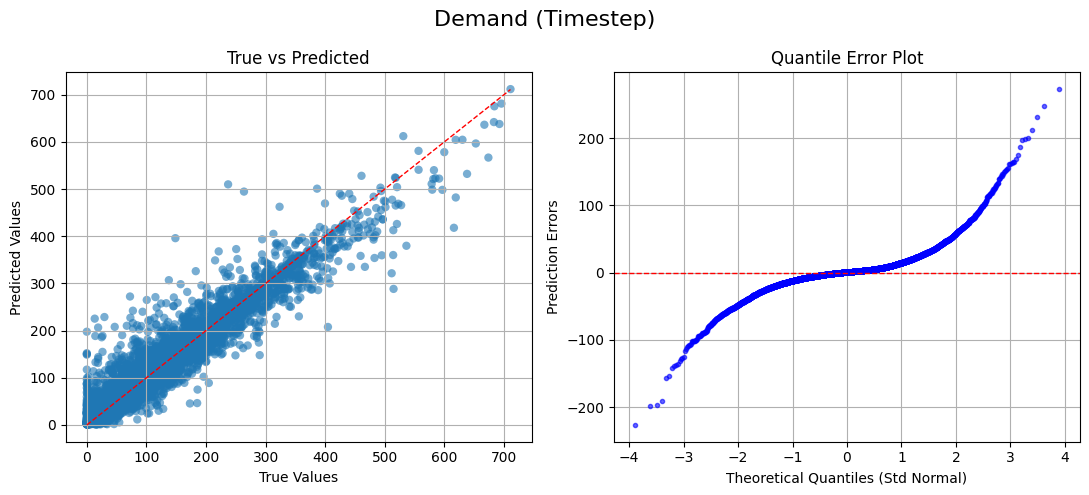

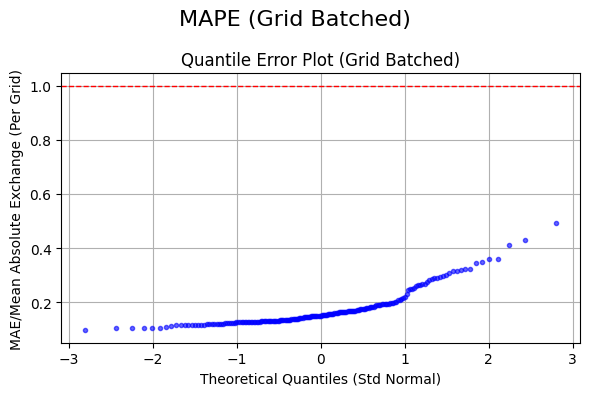

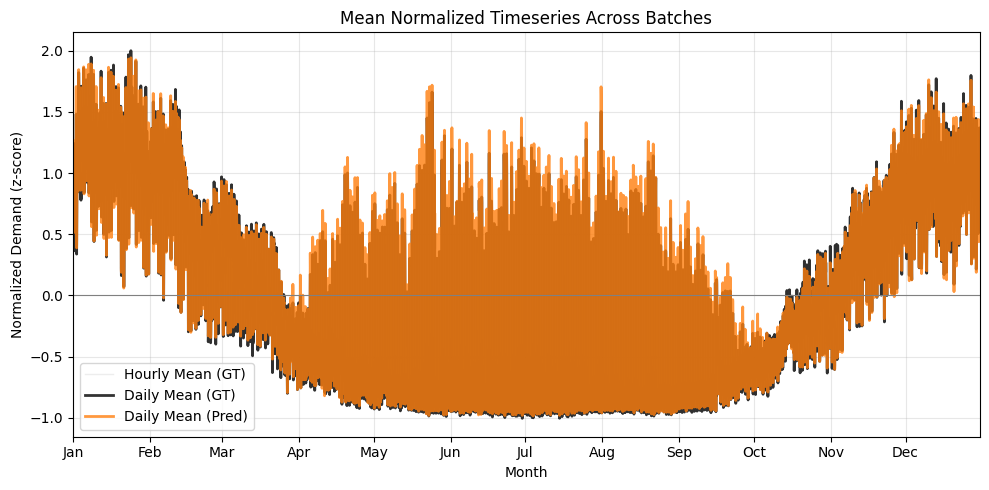

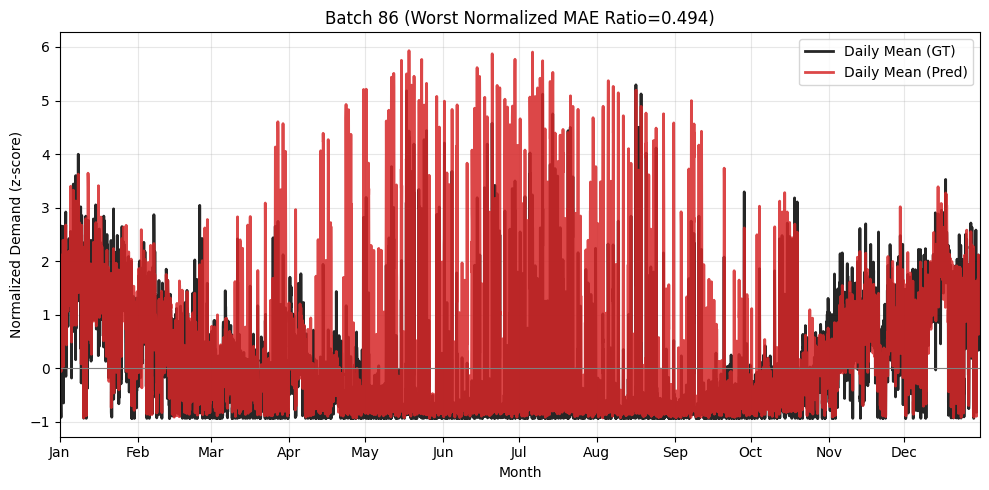

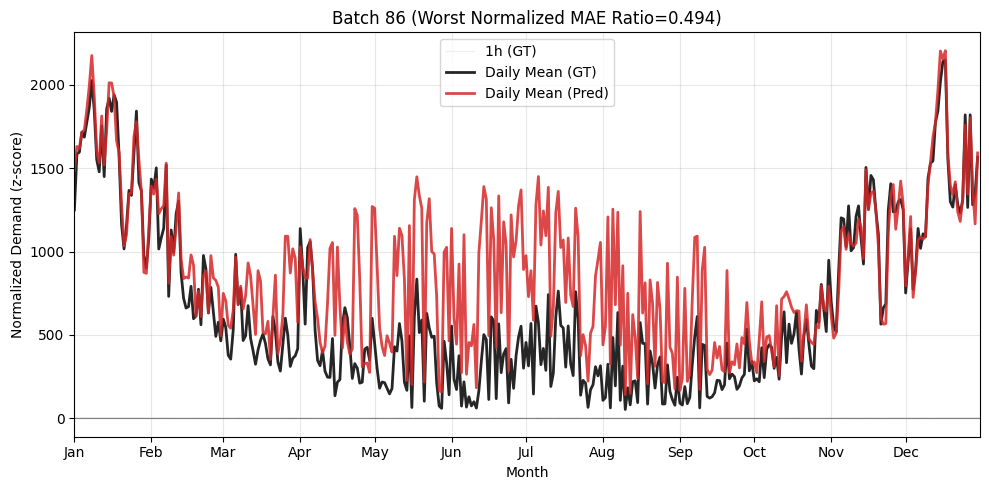

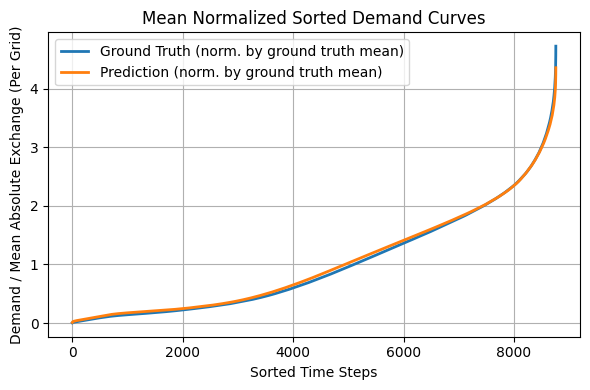

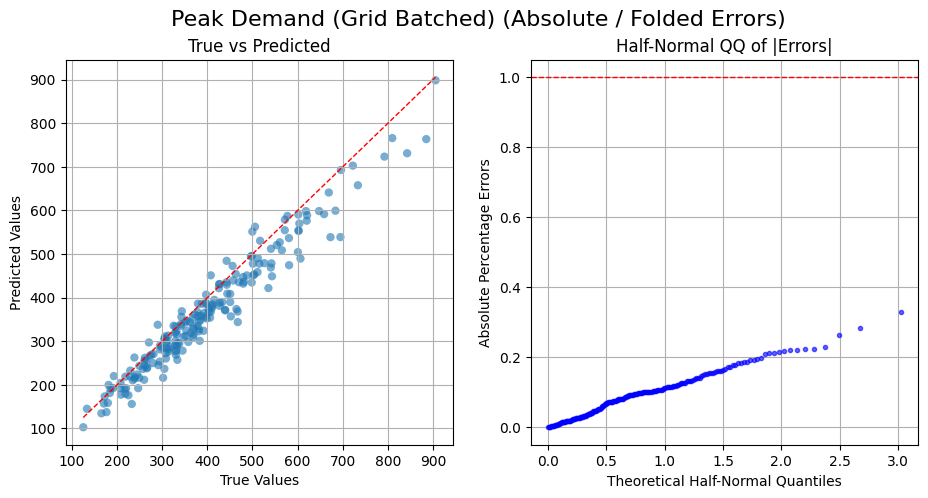

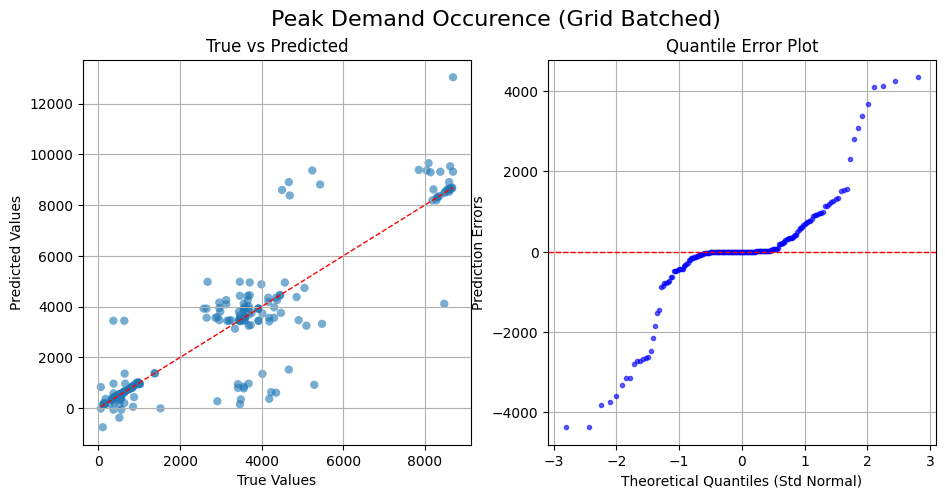

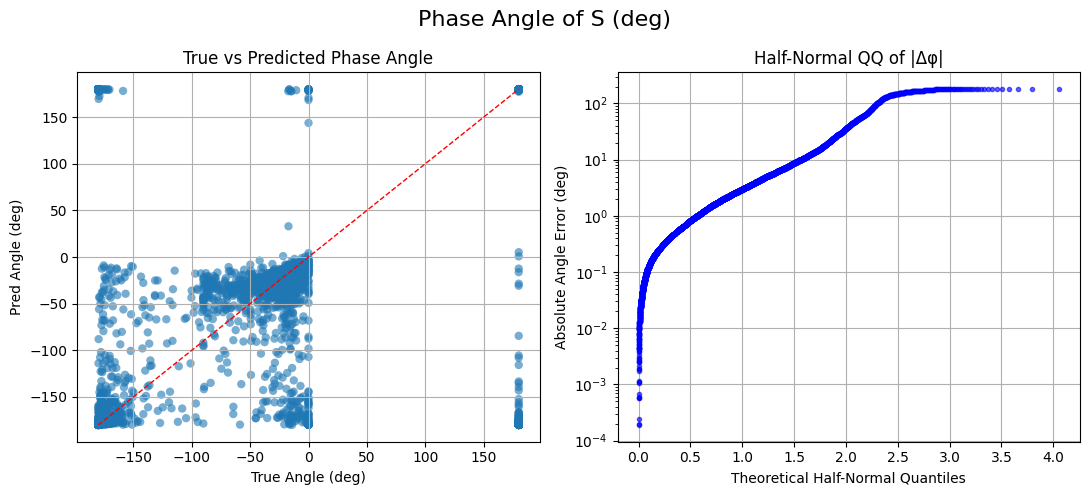

Phase Angle of S metrics (deg):
  Phase Angle MAE (deg) (1h): 7.6556
  Phase Angle MAE (deg) (2h): 6.3012
  Phase Angle MAE (deg) (4h): 5.5573
  Phase Angle MAE (deg) (12h): 5.7332
  Phase Angle MAE (deg) (24h): 5.0865


{'P': None,
 'Q': None,
 'S': None,
 'S_angle': {'Phase Angle MAE (deg) (1h)': 7.65558448256988,
  'Phase Angle MAE (deg) (2h)': 6.301183546839794,
  'Phase Angle MAE (deg) (4h)': 5.55728166277359,
  'Phase Angle MAE (deg) (12h)': 5.733208455062276,
  'Phase Angle MAE (deg) (24h)': 5.086476271784633}}

In [5]:
transformer_trainer.evaluate_best_with_plots() ### test